In [52]:
using ReactionMechanismSimulator
using PyPlot
using DifferentialEquations
using Sundials
using SciMLBase
using QuadGK

In [53]:
outdict = readinput("Ag_C2_042925.rms")

[13:13:23] WARNING: not removing hydrogen atom without neighbors
[13:13:23] WARNING: not removing hydrogen atom without neighbors
┌ Warning: failed to generate StokesDiffusivity model for species vacantX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CO2X
└ @ ReactionMechanismSimulator /home/ssun30/RMG-electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CHO2X
└ @ ReactionMechanismSimulator /home/ssun30/RMG-electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CO2HX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species OCX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-electrocat/ReactionMechanismSimulator.j

Dict{Any, Any} with 4 entries:
  "Solvents"              => Solvent[Solvent("water", RiedelViscosity{Float64}(…
  Set(["surface", "gas"]) => Dict{Any, Any}("Reactions"=>ElementaryReaction[vac…
  "gas"                   => Dict{Any, Any}("Species"=>Species[Species{NASA{Emp…
  "surface"               => Dict{Any, Any}("Species"=>Species[Species{NASA{Emp…

In [54]:
liqspcs = outdict["gas"]["Species"]
liqrxns = outdict["gas"]["Reactions"]
surfspcs = outdict["surface"]["Species"]
surfrxns = outdict["surface"]["Reactions"]
interfacerxns = outdict[Set(["surface", "gas"])]["Reactions"]
solv = outdict["Solvents"][1];

In [55]:
sitedensity = 2.292e-5; # Ag111
liq = IdealDiluteSolution(liqspcs,liqrxns,solv,name="liquid",diffusionlimited=true);
surf = IdealSurface(surfspcs,surfrxns,sitedensity,name="surface");

In [56]:
# Reservoir is a 100 mL (100e-6 m^3) cell
# Proton concentration is 10^-7 mol/L (10^-4 mol/m^3)
# CO2 concentration is 0.01 mol/L (10 mol/m^3), saturation solubility ~0.03 mol/L
# Solvent concentration (water) is 55.6 mol/L (5.56e4 mol/m^3)
# AVratio in experiments is 36 m^-1 but is measured by surface area/reservoir volume
# Area of the electrode is therefore 3.6e1 m^-1 * 1e2*1e-6 m^3 = 3.6e-3 m^2 = 36 cm^2
# Assume boundary layer thickness d_bl = 1 mm or 1e-3 m
# Volume of the boundary layer V_bl = 3.6e-3 m^2 * 1e-3 m = 3.6e-6 m^3
# Actual AVratio is therefore 3.6e-3 m^2 / 3.6e-6 m^3 = 1e3 m^-1 (reciprocal of d_bl)
# Amount of sites is 2.292e-5 mol/m^2 * 1e3 m^-1 = 2.292e-2 mol/m^-3

C_proton = 1.0e-7*1.0e3;
C_co2 = 1.0e-2*1.0e3;
C_h2o = 5.56e4;
C_default = 1e-12;
V_res = 1.0e3;
AVratio = 1.0e3;
A_surf = V_res*36;
V_bl = V_res;
sites = sitedensity*A_surf;

initialcondsliq = Dict(["proton"=>C_proton * V_res,
                        "CO2"=>C_co2 * V_res,
                        "H2O"=>C_h2o * V_res,
                        "V"=>V_res,"T"=>300,"Phi"=>0.0,"d"=>0.0]);

initialcondssurf = Dict(["CO2X"=>0.4*sites,
        # "CHO2X"=>0.1*sites,
        # "CO2HX"=>0.1*sites,
        # "OX"=>0.1*sites,
        # "OCX"=>0.1*sites,
        "vacantX"=>0.6*sites,
        # "CH2O2X"=>0.05*sites,
        # "CHOX"=>0.04*sites,
        # "CH2OX"=>0.01*sites,
        "A"=>A_surf,"T"=>300,"Phi"=>-1.414]);

In [57]:
domainliq,y0liq,pliq = ConstantTVDomain(phase=liq,
    initialconds=initialcondsliq,constantspecies=["proton","CO2","H2O"]);
domaincat,y0cat,pcat = ConstantTAPhiDomain(phase=surf,
    initialconds=initialcondssurf);

In [58]:
inter,pinter = ReactiveInternalInterfaceConstantTPhi(domainliq,
  domaincat,interfacerxns,298.15,A_surf);

In [59]:
@time react,y0,p = Reactor((domainliq,domaincat), (y0liq,y0cat), (0.0, 1.0e3), [inter], (pliq,pcat,pinter));


  0.003364 seconds (8.83 k allocations: 7.921 MiB)


In [60]:
@time sol = solve(react.ode,DifferentialEquations.CVODE_BDF(),abstol=1e-22,reltol=1e-8);
println(sol.t[end]);
println(sol.retcode);

  0.324096 seconds (893.95 k allocations: 518.367 MiB, 19.53% gc time)
1000.0
Success


In [61]:
ssys = SystemSimulation(sol,(domainliq,domaincat,),(inter,),p);

In [62]:
# Helper function
function plotX(sim, tol, t_end, exclude)
    clf()
    xs = molefractions(sim)
    maxes = maximum(xs, dims=2)

    # Filter time data up to t_end
    time_indices = findall(t -> t <= t_end, sim.sol.t)
    time_filtered = sim.sol.t[time_indices]
    xs_filtered = xs[:, time_indices]

    for i = 1:length(maxes)
        species_name = sim.domain.phase.species[i].name
        if maxes[i] > tol && !(species_name in exclude)
            plot(time_filtered, xs_filtered[i,:], label=species_name)
        end
    end
    legend()
    xlabel("Time in Sec")
    ylabel("Mole Fraction")
end

plotX (generic function with 1 method)

In [63]:
# Helper function
function plotC(sim, tol, t_end, exclude)
    clf()
    xs = concentrations(sim)
    maxes = maximum(xs, dims=2)

    # Filter time data up to t_end
    time_indices = findall(t -> t <= t_end, sim.sol.t)
    time_filtered = sim.sol.t[time_indices]
    xs_filtered = xs[:, time_indices]

    for i = 1:length(maxes)
        species_name = sim.domain.phase.species[i].name
        if maxes[i] > tol && !(species_name in exclude)
            plot(time_filtered, xs_filtered[i,:], label=species_name)
        end
    end
    legend()
    xlabel("Time in Sec")
    ylabel("Concentration")
end

plotC (generic function with 1 method)

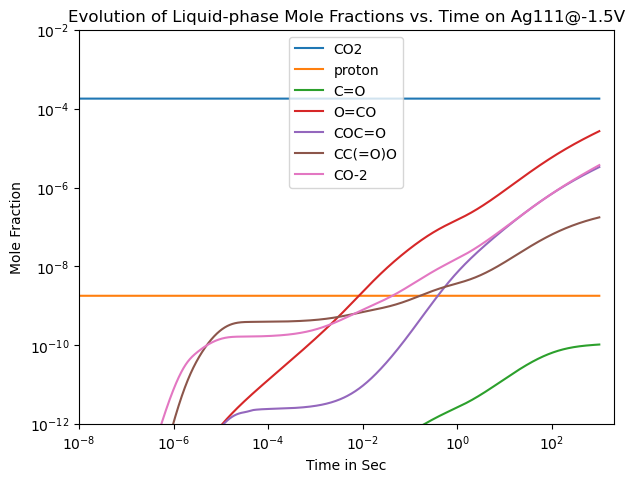

In [64]:
exclude_species = ["H2O"]
plotX(ssys.sims[1], 1e-10, 1.8e3, exclude_species)
xscale("log")
yscale("log")
xlim(1e-8, 2e3)
ylim(1e-12, 1e-2)
title("Evolution of Liquid-phase Mole Fractions vs. Time on Ag111@-1.5V")
gcf()

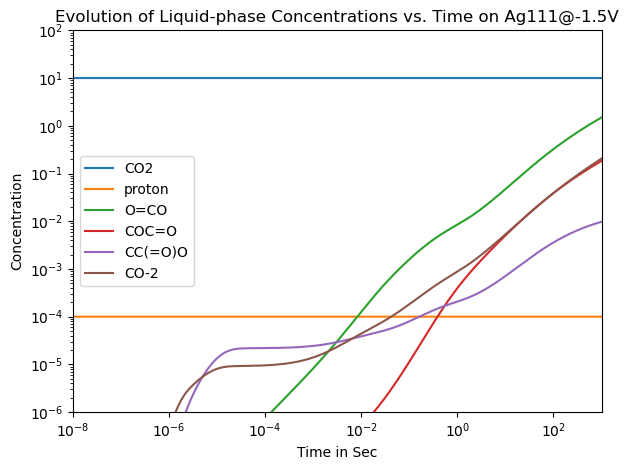

In [75]:
exclude_species = ["H2O"]
plotC(ssys.sims[1], 1e-5, 1.0e3, exclude_species)
xscale("log")
yscale("log")
xlim(1e-8, 1e3)
ylim(1e-6, 1e2)
title("Evolution of Liquid-phase Concentrations vs. Time on Ag111@-1.5V")
gcf()

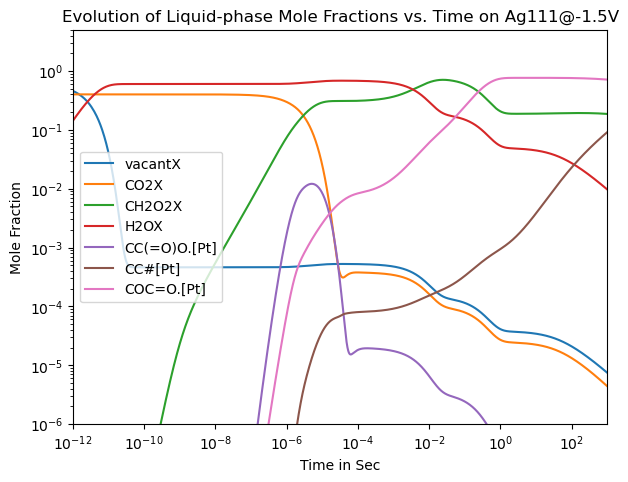

In [66]:
exclude_species = ["H2O"]
plotX(ssys.sims[2], 1e-2, 1e3, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 1e3)
ylim(1e-6, 5)
title("Evolution of Liquid-phase Mole Fractions vs. Time on Ag111@-1.5V")
gcf()

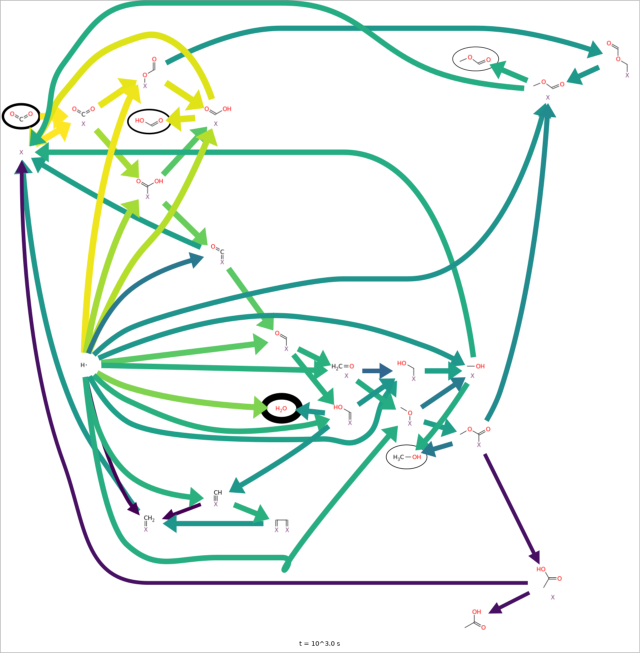

In [67]:
getfluxdiagram(ssys,1e3;speciesratetolerance=1e-6)

In [68]:
function plotROP(ssys,name,t;N=0,tol=0.01)
    clf()
    rop = rops(ssys, name, t)
    inds = rop.nzind[reverse(sortperm(abs.(rop.nzval)))]
    if N == 0
        N = length(inds)
    elseif N > length(inds)
        N = length(inds)
    end
    inds = inds[1:N]
    mval = abs(rop[inds[1]])
    minval = mval*tol
    k = 1
    while k < length(inds) && abs(rop[inds[k]]) >= minval
        k += 1
    end
    inds = inds[1:k]
    net_rops = sum(rop[inds])
    println("Net ROPs for species $name is: $net_rops")

    for (i, j) in enumerate(inds)
        println("Showing the reaction with $i th highest ROP for species $name:")
        println(getrxnstr(ssys.reactions[j]))
        println("ROP = ", rop[inds[i]])
        println(ssys.reactions[j].kinetics)
    end

    xs = Array{Float64,1}(1:length(inds))
    barh(xs,reverse(rop[inds]))
    yticks(xs,reverse(getrxnstr.(ssys.reactions[inds])))
    xlabel("Production/Loss Rate mol/s")
    gcf()
end

plotROP (generic function with 1 method)

In [69]:
"""
Integrates the ROP in the boundary layer and computes the concentration
"""
function get_boundary_layer_concentration(sim,t,spc,Vbl,C_0)
    intg,err = quadgk(x -> sum(rops(sim,spc,t)), 0, t);
    return C_0 + intg ./ Vbl;
end

get_boundary_layer_concentration

In [ ]:
# Logarithmic time scale
t_vals = 10 .^ range(-12, stop=3, length=1000);

# Compute ROP over time
ROP_vals = [sum(rops(ssys, "O=CO", t)) for t in t_vals];
# Compute boundary layer accumulation by integration
Cbl_vals = [get_boundary_layer_concentration(ssys, t, "O=CO", V_bl, C_default) for t in t_vals];

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


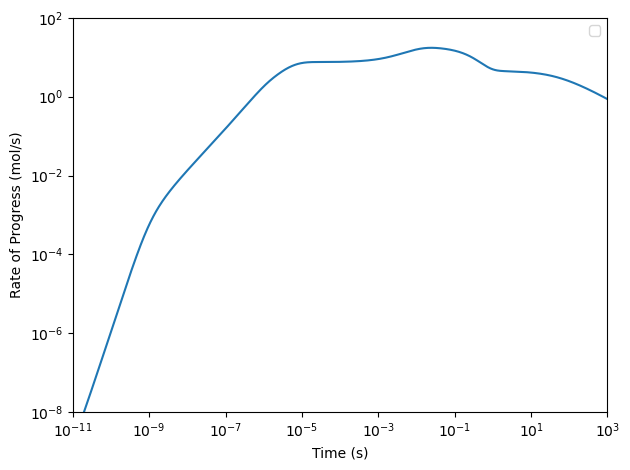

In [71]:
# Plots the ROP of O=CO
clf()

plot(t_vals, ROP_vals)

xscale("log")
xlim(1e-11,1e3)
yscale("log")
ylim(1e-8,1e2)
xlabel("Time (s)")
ylabel("Rate of Progress (mol/s)")
legend()
tight_layout()
gcf()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


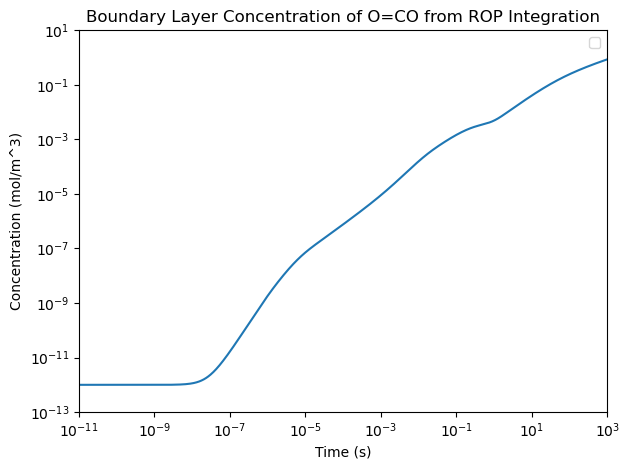

In [ ]:
# Plots the Boundary Layer Concentration of O=CO from ROP Integration WITHOUT Diffusion Flux Into Reservoir
clf()

plot(t_vals, Cbl_vals)

xscale("log")
xlim(1e-11,1e3)
yscale("log")
ylim(1e-13,1e1)
xlabel("Time (s)")
ylabel("Concentration (mol/m^3)")
title("Boundary Layer Accumulation of O=CO from ROP Integration")
legend()
tight_layout()
gcf()

In [73]:
rops(ssys,"O=CO",1)

1507-element SparseArrays.SparseVector{Float64, Int64} with 13 stored entries:
  [1329]  =  4.93052
  [1330]  =  2.47097e-18
  [1334]  =  1.90726e-20
  [1335]  =  8.41519e-25
  [1382]  =  5.09286e-16
  [1429]  =  1.11637e-9
  [1466]  =  2.47701e-9
  [1476]  =  -3.97882e-23
  [1480]  =  2.23586e-21
  [1482]  =  -4.77469e-32
  [1495]  =  3.0577e-7
  [1498]  =  8.25581e-21
  [1500]  =  5.02641e-30

In [82]:
concentrations(ssys,"O=CO",1e3)

1.4953198336508606

In [83]:
Cbl_vals[end]

0.8667719072294274

In [80]:
concentrations(ssys,1e3)

101-element Vector{Float64}:
  0.0
  0.0
  0.0
  0.0
 10.0
  9.999999999999999e-5
  0.0
  5.8044933978456105e-6
  1.4953198336508606
  1.326212079687479e-53
  ⋮
  2.101831965253404e-6
  4.989543828025639e-27
  2.944554505137183e-28
  1.6334751634574246e-5
  3.2907339687809483e-13
  1.5851318841390273e-29
  2.0754716608442726e-40
  6.7655561558769405e-15
  2.2024084677739304e-11